# 1.F: Bayesian analysis with background

The previous tutorial showed how the joint likelihood function can be calculated.
With that, and the prior probability distribution for the parameters, we can
calculate the joint posterior probability distribution for the parameters.

### Markov Chain Monte Carlo

MCMC is powerful approach to explore the posterior probability distribution when there are many parameters.

A simple recipe can produce a set of points in the multidimensional parameter space, whose
density follows the posterior probability distribution.

With those points, we can visualize the probability density in lower dimensions (1 or 2), by simple marginalization (aka projection).

In [1]:
# Import modules needed for this tutorial

from trisep.RadioactiveSource import RadioactiveSource
from trisep.RadiationCounter import RadiationCounter, SimulatedRadiationCounter
from trisep.MarkovChain import MarkovChain
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') # only include this if you use a dark background for Jupyter Lab

In [2]:
# Consider the following observed data:
# - with source inserted: 6 counts seen in 10 seconds
# - without source inserted: 5 counts seen in 30 seconds

observed = 6
observed_control = 5

# make model of control experiment (no source)

sim_control_detector = SimulatedRadiationCounter()
sim_control_detector.set_counting_time(30.)
sim_control_time = sim_control_detector.get_counting_time()

# make model of experiment with source

simulated_source = RadioactiveSource(0.6) # specifies the activity of simulated source

sim_detector = SimulatedRadiationCounter()
sim_detector.set_counting_time(10)
sim_detector.insert_known_source(simulated_source)

Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)


In [3]:
#calculate the log of the posterior probability density

def logP(params):
    a = params['a']
    b = params['b']
    simulated_source.set_activity(a)
    sim_detector.set_background(b)
    sim_likelihood = sim_detector.get_likelihood(observed)
    sim_control_detector.set_background(b)
    sim_control_likelihood = sim_control_detector.get_likelihood(observed_control)
    # assuming uniform priors for the parameters:
    result = np.log(sim_likelihood*sim_control_likelihood)
    return result

parameters = [
    {'name':'a','start':0.4,'step':0.1,'min':0.02,'max':1.2},
    {'name':'b','start':0.2,'step':0.1,'min':0.04,'max':0.4}
]
mcmc = MarkovChain(parameters, logP)
chain = mcmc.get_chain(10000) # increase to 100000 for a better view

100%|██████████| 10000/10000 [00:01<00:00, 5687.59it/s]

Acceptance fraction: 0.706


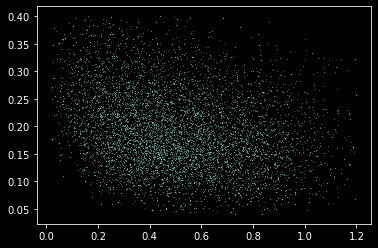

In [4]:
# scatterplot of all points in the chain

plt.scatter([dict['a'] for dict in chain], [dict['b'] for dict in chain], s=0.02)
plt.show()

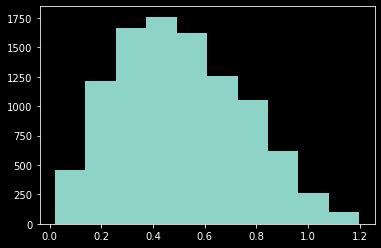

90% credible interval for activity: [ 0.144 , 0.929 ]


In [5]:
# make projection to activity axis, and find 90% credible interval

a_list = [dict['a'] for dict in chain]
plt.hist(a_list)
plt.show()

a_low = np.percentile(a_list,5.)
a_high = np.percentile(a_list,95.)

print('90% credible interval for activity: [',round(a_low,3),',',round(a_high,3),']')

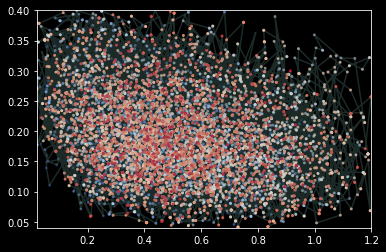

In [6]:
# show how the chain of points is constructed

mc = chain
x = [dict['a'] for dict in mc]
y = [dict['b'] for dict in mc]
plt.plot(x, y, alpha=0.2)
plt.scatter(x,y,c=np.arange(0,1,1/len(x)), alpha=np.arange(0,1,1/len(x)), cmap='coolwarm', marker='o', s=4)
plt.xlim(0.02,1.2)
plt.ylim(0.04,0.40)
plt.show()

In [7]:
# repeat the analysis above, this time with a well understood background rate 
# Low background: (b = 0.12 +/- 0.02)
# High background: (b = 0.25 +/- 0.02)
# NOTE: take smaller steps in b direction 

#calculate the log of the posterior probability density

prior_b_mean = 0.12
prior_b_sigma = 0.02

def logP_alt(params):
    a = params['a']
    b = params['b']
    simulated_source.set_activity(a)
    sim_detector.set_background(b)
    sim_likelihood = sim_detector.get_likelihood(observed)
    sim_control_detector.set_background(b)
    sim_control_likelihood = sim_control_detector.get_likelihood(observed_control)
    # assuming non-uniform prior for the background rate:
    result = np.log(sim_likelihood * sim_control_likelihood) - 0.5*((b*prior_b_mean)/prior_b_sigma)**2
    return result

parameters = [
    {'name':'a','start':0.4,'step':0.1,'min':0.02,'max':1.2},
    {'name':'b','start':prior_b_mean,'step':prior_b_sigma,'min':0.04,'max':0.4}
]
mcmc_alt = MarkovChain(parameters, logP_alt)
chain_alt = mcmc_alt.get_chain(1000000) # increase to 100000 for a better view

100%|██████████| 1000000/1000000 [02:47<00:00, 5975.29it/s]

Acceptance fraction: 0.881009


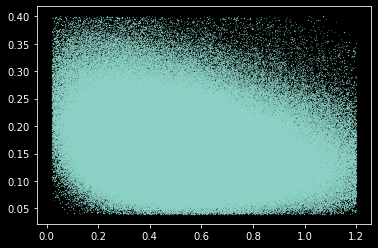

In [10]:
# scatterplot of all points in the chain

plt.scatter([dict['a'] for dict in chain_alt], [dict['b'] for dict in chain_alt], s=0.02)
plt.show()

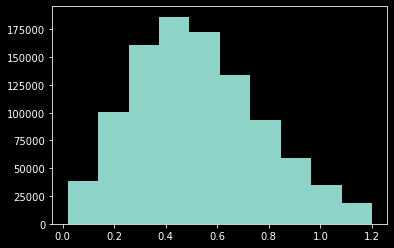

90% credible interval for activity: [ 0.157 , 0.973 ]


In [9]:
# make projection to activity axis, and find 90% credible interval

a_list_alt = [dict['a'] for dict in chain_alt]
plt.hist(a_list_alt)
plt.show()

a_low_alt = np.percentile(a_list_alt,5.)
a_high_alt = np.percentile(a_list_alt,95.)

print('90% credible interval for activity: [',round(a_low_alt,3),',',round(a_high_alt,3),']')